# Explore here

In [1096]:
import pandas as pd
import requests
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

from sklearn.feature_selection import mutual_info_regression, SelectKBest

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge

from sklearn.metrics import mean_squared_error, r2_score

url = "https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv"
df = pd.read_csv(url)
df.to_csv("../data/raw/data.csv", index=False)
df.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


In [1097]:
#Informacion general de la data
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 108 columns):
 #    Column                                                                         Dtype  
---   ------                                                                         -----  
 0    fips                                                                           int64  
 1    TOT_POP                                                                        int64  
 2    0-9                                                                            int64  
 3    0-9 y/o % of total pop                                                         float64
 4    19-Oct                                                                         int64  
 5    10-19 y/o % of total pop                                                       float64
 6    20-29                                                                          int64  
 7    20-29 y/o % of total pop                         

In [1098]:
#Duplicados de la data
print(df.isnull().values.any())

False


La data no presenta datos duplicados. 

In [1099]:
#Agrupacion de las edades para lograr ver un dataset mas limpio
if all(col in df.columns for col in ["TOT_POP", "19-Oct", "80+", "80+ y/o % of total pop"]):
    df["Total_poblacion"] = df["TOT_POP"]
    df["Edad_0-19"] = df["0-9"] + df["19-Oct"] + (df["10-19 y/o % of total pop"] *100 /df["TOT_POP"])
    df["Edad_20-39"] = df["20-29"] + df["30-39"] + (df["20-29 y/o % of total pop"] *100 /df["TOT_POP"])
    df["Edad_40-59"] = df["40-49"] + df["50-59"] + (df["40-49 y/o % of total pop"] *100 /df["TOT_POP"])
    df["Edad_60-80+"] = df["60-69"] + df["70-79"] + df["80+"] + (df["60-69 y/o % of total pop"] *100 /df["TOT_POP"])

else:
    print(df.columns)
df

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code,Total_poblacion,Edad_0-19,Edad_20-39,Edad_40-59,Edad_60-80+
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3.1,2.9,3.3,1326,3,55601,14424.024703,13967.022248,15320.024526,11890.018845
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,3.2,3.0,3.5,5479,4,218022,51670.005662,48792.004960,57324.005751,60236.006297
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,4.5,4.2,4.8,887,6,24881,5692.047814,6469.052789,6352.049656,6368.049688
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,3.3,3.1,3.6,595,2,22400,5052.051738,6142.060368,6153.060547,5053.050721
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,3.4,3.2,3.7,1507,2,57840,14665.022628,13626.020153,15318.022341,14231.020819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,56037,43051,6104,14.178532,6326,14.694200,5359,12.448027,6577,15.277229,...,2.6,2.4,2.8,821,5,43051,12430.034132,11936.028915,10595.028780,8090.026670
3136,56039,23081,2384,10.328842,2185,9.466661,2967,12.854729,4093,17.733200,...,2.4,2.2,2.6,447,5,23081,4569.041015,7060.055694,6351.064254,5101.053967
3137,56041,20299,3121,15.375142,3205,15.788955,2153,10.606434,2702,13.311001,...,3.0,2.8,3.2,430,5,20299,6326.077782,4855.052251,4824.058003,4294.061983
3138,56043,7885,858,10.881420,1113,14.115409,715,9.067850,903,11.452124,...,3.4,3.2,3.7,207,6,7885,1971.179016,1618.115001,1985.144757,2311.179820


In [1100]:
columnas_a_eliminar = df.filter(regex="^[0-9]+-[0-9]+").columns.tolist()  #Elimana las edades especificas
columnas_a_eliminar.extend(["TOT_POP", "19-Oct", "80+", "80+ y/o % of total pop"]) #Elimina las columnas agregadas
df = df.drop(columns=columnas_a_eliminar, errors="ignore")
df

,fips,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,...,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code,Total_poblacion,Edad_0-19,Edad_20-39,Edad_40-59,Edad_60-80+
0,1001,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,...,3.1,2.9,3.3,1326,3,55601,14424.024703,13967.022248,15320.024526,11890.018845
1,1003,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,...,3.2,3.0,3.5,5479,4,218022,51670.005662,48792.004960,57324.005751,60236.006297
2,1005,12209,49.069571,12042,48.398376,164,0.659137,113,0.454162,46,...,4.5,4.2,4.8,887,6,24881,5692.047814,6469.052789,6352.049656,6368.049688
3,1007,17211,76.834821,4770,21.294643,98,0.437500,53,0.236607,26,...,3.3,3.1,3.6,595,2,22400,5052.051738,6142.060368,6153.060547,5053.050721
4,1009,55456,95.878285,950,1.642462,378,0.653527,185,0.319848,70,...,3.4,3.2,3.7,1507,2,57840,14665.022628,13626.020153,15318.022341,14231.020819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,56037,40397,93.835219,592,1.375113,665,1.544680,435,1.010429,68,...,2.6,2.4,2.8,821,5,43051,12430.034132,11936.028915,10595.028780,8090.026670
3136,56039,21971,95.190850,175,0.758199,211,0.914172,326,1.412417,35,...,2.4,2.2,2.6,447,5,23081,4569.041015,7060.055694,6351.064254,5101.053967
3137,56041,19356,95.354451,168,0.827627,288,1.418789,96,0.472930,30,...,3.0,2.8,3.2,430,5,20299,6326.077782,4855.052251,4824.058003,4294.061983
3138,56043,7450,94.483196,40,0.507292,143,1.813570,65,0.824350,8,...,3.4,3.2,3.7,207,6,7885,1971.179016,1618.115001,1985.144757,2311.179820


In [1101]:
# Agrupamos los datos demograficos, migracion, natalidad/mortalidad y 
# niveles educativos en categorias 
df["White_Pop"] = df["White-alone pop"]
df["Black_Pop"] = df["Black-alone pop"]
df["Native_Pop"] = df["Native American/American Indian-alone pop"]
df["Asian_Pop"] = df["Asian-alone pop"]
df["Hawaiian_Pop"] = df["Hawaiian/Pacific Islander-alone pop"]
df["Mixed_Pop"] = df["Two or more races pop"]
df["White_Pop_Percent"] = df["% White-alone"]
df["Black_Pop_Percent"] = df["% Black-alone"]
df["Native_Pop_Percent"] = df["% NA/AI-alone"]
df["Asian_Pop_Percent"] = df["% Asian-alone"]
df["Hawaiian_Pop_Percent"] = df["% Hawaiian/PI-alone"]
df["Mixed_Pop_Percent"] = df["% Two or more races"]
df["Total_Population"] = df["POP_ESTIMATE_2018"]
df["Population_Change"] = df["N_POP_CHG_2018"]
df["Group_Quarters_Estimates"] = df["GQ_ESTIMATES_2018"]
df["Birth_Rate"] = df["R_birth_2018"]
df["Death_Rate"] = df["R_death_2018"]
df["Natural_Increase"] = df["R_NATURAL_INC_2018"]
df["International_Migration"] = df["R_INTERNATIONAL_MIG_2018"]
df["Domestic_Migration"] = df["R_DOMESTIC_MIG_2018"]
df["Net_Migration"] = df["R_NET_MIG_2018"]
df["No_High_School"] = df["Less than a high school diploma 2014-18"]
df["High_School_Only"] = df["High school diploma only 2014-18"]
df["Some_College"] = df["Some college or associate's degree 2014-18"]
df["Bachelor_or_Higher"] = df["Bachelor's degree or higher 2014-18"]
df

,fips,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,...,Birth_Rate,Death_Rate,Natural_Increase,International_Migration,Domestic_Migration,Net_Migration,No_High_School,High_School_Only,Some_College,Bachelor_or_Higher
0,1001,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,...,11.8,9.6,2.2,0.0,0.7,0.6,4204,12119,10552,10291
1,1003,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,...,10.5,10.3,0.1,0.5,24.3,24.8,14310,40579,46025,46075
2,1005,12209,49.069571,12042,48.398376,164,0.659137,113,0.454162,46,...,10.4,12.9,-2.5,0.5,-9.1,-8.6,4901,6486,4566,2220
3,1007,17211,76.834821,4770,21.294643,98,0.437500,53,0.236607,26,...,11.1,11.4,-0.3,0.4,-7.0,-6.6,2650,7471,3846,1813
4,1009,55456,95.878285,950,1.642462,378,0.653527,185,0.319848,70,...,11.8,11.4,0.3,0.1,-0.2,0.0,7861,13489,13267,5010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,56037,40397,93.835219,592,1.375113,665,1.544680,435,1.010429,68,...,12.6,7.0,5.6,1.4,-18.5,-17.2,2549,9433,10108,6243
3136,56039,21971,95.190850,175,0.758199,211,0.914172,326,1.412417,35,...,9.9,3.2,6.7,1.6,-16.2,-14.5,958,2272,4087,9847
3137,56041,19356,95.354451,168,0.827627,288,1.418789,96,0.472930,30,...,13.5,7.2,6.3,0.0,-14.0,-14.1,934,5176,4810,1995
3138,56043,7450,94.483196,40,0.507292,143,1.813570,65,0.824350,8,...,9.3,10.7,-1.4,-0.6,-16.6,-17.2,590,1717,2135,1220


In [1102]:
# Agrupamos aspectos socioeconomicos, salud y demografia en varias categorias
df["Labor_Force"] = df["Civilian_labor_force_2018"]
df["Employed"] = df["Employed_2018"]
df["Unemployed"] = df["Unemployed_2018"]
df["Unemployment_Rate"] = df["Unemployment_rate_2018"]
df["Median_Income"] = df["Median_Household_Income_2018"]
df["Income_Percent_State"] = df["Med_HH_Income_Percent_of_State_Total_2018"]
df["Total_Physicians"] = df["Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)"]
df["Primary_Care_Physicians"] = df["Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)"]
df["General_Surgeons"] = df["Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)"]
df["Nurse_Practitioners"] = df["Total nurse practitioners (2019)"]
df["Physician_Assistants"] = df["Total physician assistants (2019)"]
df["Total_Hospitals"] = df["Total Hospitals (2019)"]
df["ICU_Beds"] = df["ICU Beds_x"]
df["Total_Population"] = df["Total Population"]
df["Senior_Population"] = df["Population Aged 60+"]
df["Senior_Percent"] = df["Percent of Population Aged 60+"]
df["County"] = df["COUNTY_NAME"]
df["State"] = df["STATE_NAME"]
df["State_FIPS"] = df["STATE_FIPS"]
df["County_FIPS"] = df["CNTY_FIPS"]
df["Urban_Rural_Code"] = df["Urban_rural_code"]
df["AnyCondition_Prevalence"] = df["anycondition_prevalence"]
df["Obesity_Prevalence"] = df["Obesity_prevalence"]
df["HeartDisease_Prevalence"] = df["Heart disease_prevalence"]
df["COPD_Prevalence"] = df["COPD_prevalence"]
df["Diabetes_Prevalence"] = df["diabetes_prevalence"]
df["CKD_Prevalence"] = df["CKD_prevalence"]
df["Obesity_CI_Lower"] = df["Obesity_Lower 95% CI"]
df["Obesity_CI_Upper"] = df["Obesity_Upper 95% CI"]
df["HeartDisease_CI_Lower"] = df["Heart disease_Lower 95% CI"]
df["HeartDisease_CI_Upper"] = df["Heart disease_Upper 95% CI"]
df["COPD_CI_Lower"] = df["COPD_Lower 95% CI"]
df["COPD_CI_Upper"] = df["COPD_Upper 95% CI"]
df["Diabetes_CI_Lower"] = df["diabetes_Lower 95% CI"]
df["Diabetes_CI_Upper"] = df["diabetes_Upper 95% CI"]
df["CKD_CI_Lower"] = df["CKD_Lower 95% CI"]
df["CKD_CI_Upper"] = df["CKD_Upper 95% CI"]
df["Total_Poverty"] = df["POVALL_2018"]
df["Overall_Poverty_Percent"] = df["PCTPOVALL_2018"]
df["Child_Poverty_0_17_Percent"] = df["PCTPOV017_2018"]
df["Child_Poverty_5_17_Percent"] = df["PCTPOV517_2018"]
df["Median_Household_Income"] = df["MEDHHINC_2018"]
df["Income_Confidence_Lower"] = df["CI90LBINC_2018"]
df["Income_Confidence_Upper"] = df["CI90UBINC_2018"]
df

,fips,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,...,Diabetes_CI_Upper,CKD_CI_Lower,CKD_CI_Upper,Total_Poverty,Overall_Poverty_Percent,Child_Poverty_0_17_Percent,Child_Poverty_5_17_Percent,Median_Household_Income,Income_Confidence_Lower,Income_Confidence_Upper
0,1001,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,...,13.8,2.9,3.3,7587,13.8,19.3,19.5,59338,53628,65048
1,1003,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,...,13.1,3.0,3.5,21069,9.8,13.9,13.1,57588,54437,60739
2,1005,12209,49.069571,12042,48.398376,164,0.659137,113,0.454162,46,...,20.6,4.2,4.8,6788,30.9,43.9,36.7,34382,31157,37607
3,1007,17211,76.834821,4770,21.294643,98,0.437500,53,0.236607,26,...,14.9,3.1,3.6,4400,21.8,27.8,26.3,46064,41283,50845
4,1009,55456,95.878285,950,1.642462,378,0.653527,185,0.319848,70,...,14.5,3.2,3.7,7527,13.2,18.0,15.5,50412,46157,54667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,56037,40397,93.835219,592,1.375113,665,1.544680,435,1.010429,68,...,9.6,2.4,2.8,3540,8.4,10.0,8.5,73315,67141,79489
3136,56039,21971,95.190850,175,0.758199,211,0.914172,326,1.412417,35,...,8.0,2.2,2.6,1443,6.3,6.7,5.9,99087,88142,110032
3137,56041,19356,95.354451,168,0.827627,288,1.418789,96,0.472930,30,...,11.2,2.8,3.2,2010,10.0,12.1,10.6,63401,56812,69990
3138,56043,7450,94.483196,40,0.507292,143,1.813570,65,0.824350,8,...,12.1,3.2,3.7,918,11.9,16.1,14.5,55190,49263,61117


In [1103]:
#Ahora eliminaremos las columnas y dejaremos las columnas creadas
columnas_a_eliminar = [
    "White-alone pop", "% White-alone", "Black-alone pop", "% Black-alone",
    "Native American/American Indian-alone pop", "% NA/AI-alone",
    "Asian-alone pop", "% Asian-alone", "Hawaiian/Pacific Islander-alone pop",
    "% Hawaiian/PI-alone", "Two or more races pop", "% Two or more races",
    "POP_ESTIMATE_2018", "N_POP_CHG_2018", "GQ_ESTIMATES_2018",
    "R_birth_2018", "R_death_2018", "R_NATURAL_INC_2018",
    "R_INTERNATIONAL_MIG_2018", "R_DOMESTIC_MIG_2018", "R_NET_MIG_2018",
    "Less than a high school diploma 2014-18", "High school diploma only 2014-18",
    "Some college or associate's degree 2014-18", "Bachelor's degree or higher 2014-18",
    "Percent of adults with less than a high school diploma 2014-18",
    "Percent of adults with a high school diploma only 2014-18",
    "Percent of adults completing some college or associate's degree 2014-18",
    "Percent of adults with a bachelor's degree or higher 2014-18",
    "POVALL_2018", "PCTPOVALL_2018", "PCTPOV017_2018", "PCTPOV517_2018",
    "MEDHHINC_2018", "CI90LBINC_2018", "CI90UBINC_2018"
]

df = df.drop(columns=columnas_a_eliminar, errors="ignore")


In [1104]:
#Ahora eliminaremos las columnas y dejaremos las columnas creadas
columnas_a_eliminar = [
    "Civilian_labor_force_2018", "Employed_2018", "Unemployed_2018",
    "Unemployment_rate_2018", "Median_Household_Income_2018",
    "Med_HH_Income_Percent_of_State_Total_2018",
    "Active Physicians per 100000 Population 2018 (AAMC)",
    "Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)",
    "Active Primary Care Physicians per 100000 Population 2018 (AAMC)",
    "Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)",
    "Active General Surgeons per 100000 Population 2018 (AAMC)",
    "Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)",
    "Total nurse practitioners (2019)", "Total physician assistants (2019)",
    "Total Hospitals (2019)", "Internal Medicine Primary Care (2019)",
    "Family Medicine/General Practice Primary Care (2019)",
    "Total Specialist Physicians (2019)", "ICU Beds_x", "Total Population",
    "Population Aged 60+", "Percent of Population Aged 60+", "COUNTY_NAME",
    "STATE_NAME", "STATE_FIPS", "CNTY_FIPS", "county_pop2018_18 and older",
    "anycondition_prevalence", "anycondition_Lower 95% CI",
    "anycondition_Upper 95% CI", "anycondition_number",
    "Obesity_prevalence", "Obesity_Lower 95% CI", "Obesity_Upper 95% CI",
    "Obesity_number", "Heart disease_prevalence",
    "Heart disease_Lower 95% CI", "Heart disease_Upper 95% CI",
    "Heart disease_number", "COPD_prevalence", "COPD_Lower 95% CI",
    "COPD_Upper 95% CI", "COPD_number", "diabetes_prevalence",
    "diabetes_Lower 95% CI", "diabetes_Upper 95% CI", "diabetes_number",
    "CKD_prevalence", "CKD_Lower 95% CI", "CKD_Upper 95% CI", "CKD_number",
    "Urban_rural_code"
]

df = df.drop(columns=columnas_a_eliminar, errors="ignore")
df

,fips,Total_poblacion,Edad_0-19,Edad_20-39,Edad_40-59,Edad_60-80+,White_Pop,Black_Pop,Native_Pop,Asian_Pop,...,Diabetes_CI_Upper,CKD_CI_Lower,CKD_CI_Upper,Total_Poverty,Overall_Poverty_Percent,Child_Poverty_0_17_Percent,Child_Poverty_5_17_Percent,Median_Household_Income,Income_Confidence_Lower,Income_Confidence_Upper
0,1001,55601,14424.024703,13967.022248,15320.024526,11890.018845,42660,10915,267,681,...,13.8,2.9,3.3,7587,13.8,19.3,19.5,59338,53628,65048
1,1003,218022,51670.005662,48792.004960,57324.005751,60236.006297,190301,19492,1684,2508,...,13.1,3.0,3.5,21069,9.8,13.9,13.1,57588,54437,60739
2,1005,24881,5692.047814,6469.052789,6352.049656,6368.049688,12209,12042,164,113,...,20.6,4.2,4.8,6788,30.9,43.9,36.7,34382,31157,37607
3,1007,22400,5052.051738,6142.060368,6153.060547,5053.050721,17211,4770,98,53,...,14.9,3.1,3.6,4400,21.8,27.8,26.3,46064,41283,50845
4,1009,57840,14665.022628,13626.020153,15318.022341,14231.020819,55456,950,378,185,...,14.5,3.2,3.7,7527,13.2,18.0,15.5,50412,46157,54667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,56037,43051,12430.034132,11936.028915,10595.028780,8090.026670,40397,592,665,435,...,9.6,2.4,2.8,3540,8.4,10.0,8.5,73315,67141,79489
3136,56039,23081,4569.041015,7060.055694,6351.064254,5101.053967,21971,175,211,326,...,8.0,2.2,2.6,1443,6.3,6.7,5.9,99087,88142,110032
3137,56041,20299,6326.077782,4855.052251,4824.058003,4294.061983,19356,168,288,96,...,11.2,2.8,3.2,2010,10.0,12.1,10.6,63401,56812,69990
3138,56043,7885,1971.179016,1618.115001,1985.144757,2311.179820,7450,40,143,65,...,12.1,3.2,3.7,918,11.9,16.1,14.5,55190,49263,61117


In [1105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 74 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   fips                        3140 non-null   int64  
 1   Total_poblacion             3140 non-null   int64  
 2   Edad_0-19                   3140 non-null   float64
 3   Edad_20-39                  3140 non-null   float64
 4   Edad_40-59                  3140 non-null   float64
 5   Edad_60-80+                 3140 non-null   float64
 6   White_Pop                   3140 non-null   int64  
 7   Black_Pop                   3140 non-null   int64  
 8   Native_Pop                  3140 non-null   int64  
 9   Asian_Pop                   3140 non-null   int64  
 10  Hawaiian_Pop                3140 non-null   int64  
 11  Mixed_Pop                   3140 non-null   int64  
 12  White_Pop_Percent           3140 non-null   float64
 13  Black_Pop_Percent           3140 

Al visualizar la informacion de la data observamos que siguen existiendo columnas con datos irrelevantes que podriamos eliminar para un obtener un dataset mas limpio y que nos de un mejor analisis acerca de nuestra variable tarjet que en este caso sera la *Obesity_Prevalence*

In [1106]:
#Elimnamos columnas con datos irrelevantes y creamos nuestro data nuevo
df_new = df.drop(columns=["fips", "White_Pop" , "Black_Pop", "Native_Pop", "Asian_Pop", "Hawaiian_Pop", "Mixed_Pop", "White_Pop_Percent", "Black_Pop_Percent", "Native_Pop_Percent", "Asian_Pop_Percent", "Hawaiian_Pop_Percent", "Mixed_Pop_Percent", "County",
                           "State", "State_FIPS", "County_FIPS", "International_Migration", "Domestic_Migration",
                           "No_High_School", "High_School_Only", "Some_College", "Bachelor_or_Higher",
                           "Income_Confidence_Lower", "Income_Confidence_Upper", "Total_Population",
                           "Population_Change", "Group_Quarters_Estimates", "Natural_Increase", "Net_Migration",
                           "Labor_Force", "Employed", "Unemployed", "Unemployment_Rate",
                           "HeartDisease_Prevalence", "COPD_Prevalence", "Diabetes_Prevalence", "CKD_Prevalence",
                           "HeartDisease_CI_Lower", "HeartDisease_CI_Upper", "COPD_CI_Lower", "COPD_CI_Upper",
                           "Diabetes_CI_Lower", "Diabetes_CI_Upper", "CKD_CI_Lower", "CKD_CI_Upper"])
df_new

,Total_poblacion,Edad_0-19,Edad_20-39,Edad_40-59,Edad_60-80+,Birth_Rate,Death_Rate,Median_Income,Income_Percent_State,Total_Physicians,...,Urban_Rural_Code,AnyCondition_Prevalence,Obesity_Prevalence,Obesity_CI_Lower,Obesity_CI_Upper,Total_Poverty,Overall_Poverty_Percent,Child_Poverty_0_17_Percent,Child_Poverty_5_17_Percent,Median_Household_Income
0,55601,14424.024703,13967.022248,15320.024526,11890.018845,11.8,9.6,59338,119.0,196.7,...,3,47.6,35.8,34.2,37.3,7587,13.8,19.3,19.5,59338
1,218022,51670.005662,48792.004960,57324.005751,60236.006297,10.5,10.3,57588,115.5,196.7,...,4,40.2,29.7,28.4,31.0,21069,9.8,13.9,13.1,57588
2,24881,5692.047814,6469.052789,6352.049656,6368.049688,10.4,12.9,34382,68.9,196.7,...,6,57.5,40.7,39.5,41.9,6788,30.9,43.9,36.7,34382
3,22400,5052.051738,6142.060368,6153.060547,5053.050721,11.1,11.4,46064,92.3,196.7,...,2,51.6,38.7,37.4,40.2,4400,21.8,27.8,26.3,46064
4,57840,14665.022628,13626.020153,15318.022341,14231.020819,11.8,11.4,50412,101.1,196.7,...,2,46.3,34.0,32.4,35.5,7527,13.2,18.0,15.5,50412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,43051,12430.034132,11936.028915,10595.028780,8090.026670,12.6,7.0,73315,117.8,199.6,...,5,40.3,33.6,32.1,35.1,3540,8.4,10.0,8.5,73315
3136,23081,4569.041015,7060.055694,6351.064254,5101.053967,9.9,3.2,99087,159.2,199.6,...,5,24.3,19.4,18.1,20.8,1443,6.3,6.7,5.9,99087
3137,20299,6326.077782,4855.052251,4824.058003,4294.061983,13.5,7.2,63401,101.8,199.6,...,5,42.2,34.2,32.5,35.7,2010,10.0,12.1,10.6,63401
3138,7885,1971.179016,1618.115001,1985.144757,2311.179820,9.3,10.7,55190,88.6,199.6,...,6,37.5,28.4,27.0,29.8,918,11.9,16.1,14.5,55190


In [1107]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Total_poblacion             3140 non-null   int64  
 1   Edad_0-19                   3140 non-null   float64
 2   Edad_20-39                  3140 non-null   float64
 3   Edad_40-59                  3140 non-null   float64
 4   Edad_60-80+                 3140 non-null   float64
 5   Birth_Rate                  3140 non-null   float64
 6   Death_Rate                  3140 non-null   float64
 7   Median_Income               3140 non-null   int64  
 8   Income_Percent_State        3140 non-null   float64
 9   Total_Physicians            3140 non-null   float64
 10  Primary_Care_Physicians     3140 non-null   float64
 11  General_Surgeons            3140 non-null   float64
 12  Nurse_Practitioners         3140 non-null   float64
 13  Physician_Assistants        3140 

El dataset contiene 3,140 registros y 28 columnas, entre ellas 21 variables float y 7 variables int64. 

-  Mi variable objetivo: *Obesity_Prevalence*
-  No hay valores nulos, todos estan completos.
-  Las variables son int o float lo cual nos sirve para un modelado numerico. 

En nuestro Dataset podemos observar que existen variales importantes como demograficas, socioeconomicas, salud publica, de acceso e indicadores a la salud publica. 


In [1108]:
df_new['Obesity_Prevalence'].describe()

count    3140.000000
mean       35.019299
std         4.517088
min        15.200000
25%        32.400000
50%        35.400000
75%        37.900000
max        49.900000
Name: Obesity_Prevalence, dtype: float64

Estadistica basica acerca de nuestro tarjet, la obesidad varia bastante en regiones, entre un 15.2% hasta un 49.9%.

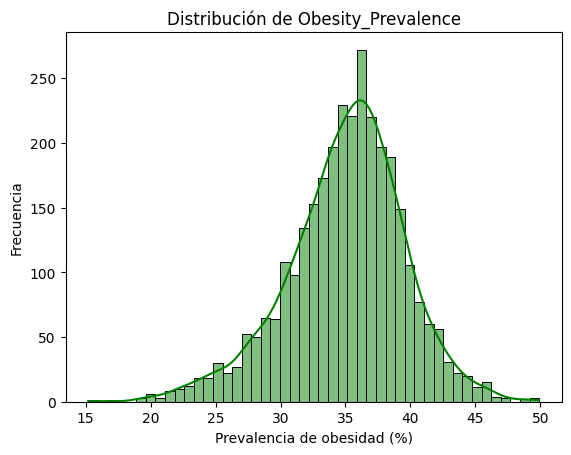

In [1109]:
# Distribucion de la variable objetivo
plt.figure()
sns.histplot(df_new['Obesity_Prevalence'], kde=True, color='green')
plt.title('Distribución de Obesity_Prevalence')
plt.xlabel('Prevalencia de obesidad (%)')
plt.ylabel('Frecuencia')
plt.show()

La obesidad parece tener una distribución concentrada en torno al 35%, pero con cierta variabilidad. Puede ser interesante cruzar esta variable con otros factores como ingresos, pobreza o acceso a atención médica para entender mejor su relación con otros factores socioeconómicos.

In [1110]:
correlation = df_new.corr(numeric_only=True)

# Correlaciones fuertes con la variable objetivo
target_corr = correlation['Obesity_Prevalence'].drop('Obesity_Prevalence')
target_corr_sorted = target_corr.sort_values(ascending=False)
print(target_corr.head())
print(target_corr_sorted.head())


Total_poblacion   -0.254358
Edad_0-19         -0.239197
Edad_20-39        -0.247641
Edad_40-59        -0.255775
Edad_60-80+       -0.274957
Name: Obesity_Prevalence, dtype: float64
Obesity_CI_Upper              0.998239
Obesity_CI_Lower              0.998117
AnyCondition_Prevalence       0.894438
Child_Poverty_0_17_Percent    0.575130
Child_Poverty_5_17_Percent    0.564820
Name: Obesity_Prevalence, dtype: float64


En zonas donde la poblacion es mas grande la obesidad es menor. Por otro lado la correlacion con adultosmayores entre 60 y 80 años la obesidad es menor, quizas por cambios en sumetabolisto o habitos alimenticios, ya que a cierta edad se regula y restringe mucho el consumo de ciertos alimentos. 

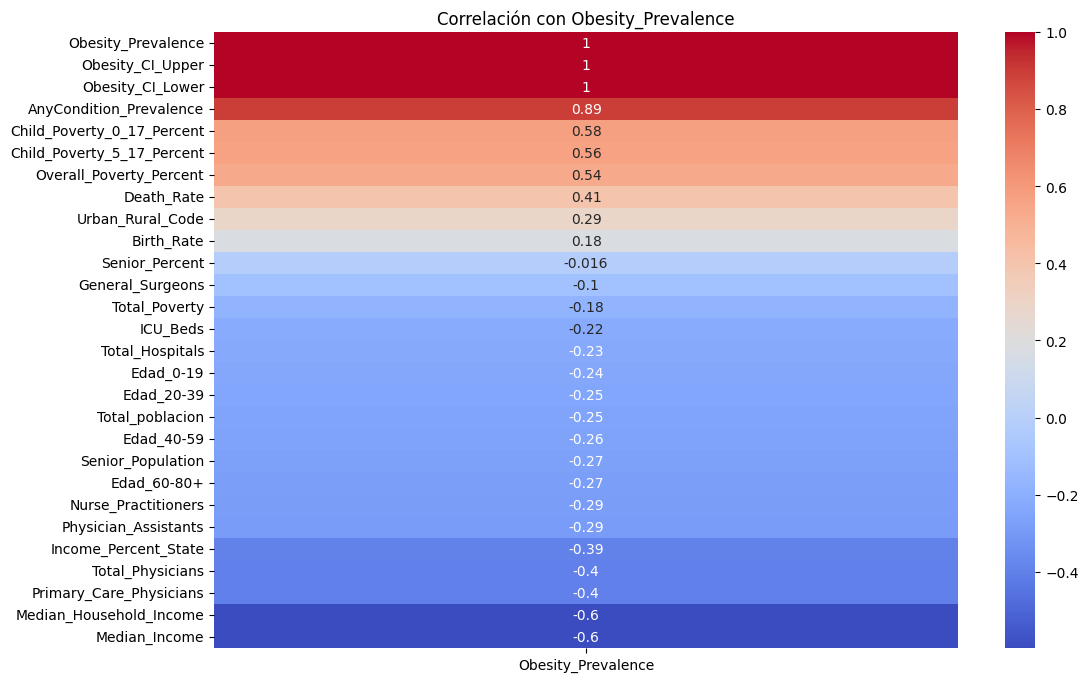

In [1111]:
#Matriz de correlacion con todas las variables

plt.figure(figsize=(12, 8))
sns.heatmap(df_new.corr(numeric_only=True)[['Obesity_Prevalence']].sort_values(by='Obesity_Prevalence', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlación con Obesity_Prevalence")
plt.show()


Variables con correlacion alta son *Obesity_CI_Upper* y *Obesity_CI_Lower* y seria logico porque son los intervalos de confianza con mi varable objetivo. *AnyCondition_Prevalance* indica que la obesidad esta relacionada con condiciones medicas y esto podria ser el causante de la aparicion de diabetes y enfermedades cardiacas. Y por otro lado el *Child_Poverty* nos dice que zonas donde hay mayor pobreza infantil la obesidad es alta, por no contar con buenos alimentos saludables o atencion medica. 
Y por ultimo, esta claro que a mayor ingreso menor prevalencia de obesidad, que en zonas donde hay mas medicos, mejor infraestructura de salud y una poblacion mas alta de adultos mayores la obesidad es menor, en comparacion con las zonas mas urbanizadas.

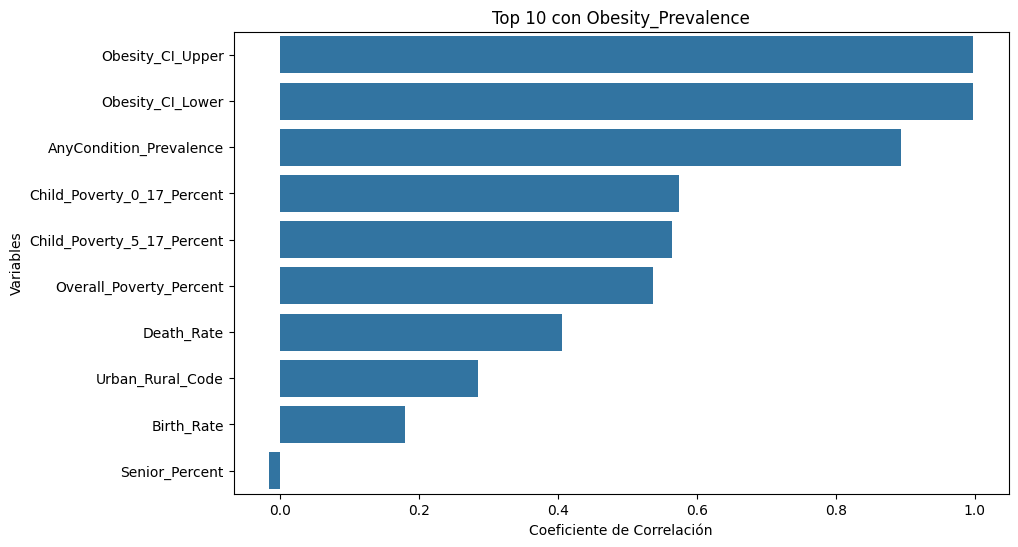

In [1112]:
#En relacion al codigo anterior vamos a analizar las 
# las 10 variables más correlacionadas a traves de un grafico de barras 
top_10_correlations = target_corr_sorted.head(10)

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_correlations.values, y=top_10_correlations.index, legend=False)
plt.xlabel("Coeficiente de Correlación")
plt.ylabel("Variables")
plt.title("Top 10 con Obesity_Prevalence")
plt.show()


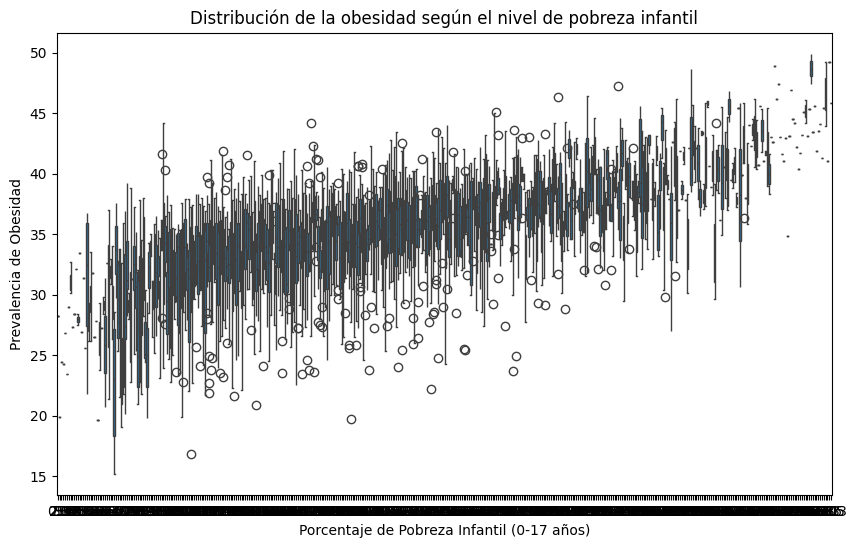

In [1113]:
# Impacto de la pobreza con la Obesidad
plt.figure(figsize=(10, 6))
sns.boxplot(x="Child_Poverty_0_17_Percent", y="Obesity_Prevalence", data=df_new)
plt.title("Distribución de la obesidad según el nivel de pobreza infantil")
plt.xlabel("Porcentaje de Pobreza Infantil (0-17 años)")
plt.ylabel("Prevalencia de Obesidad")
plt.show()


A medida que la pobreza aumenta la obesidad suele ser mayor. Podemos pensar que en lugares donde existe mucha pobreza infantil la dieta depende de muchos productos procesados y poco nutritivo, otro factor seria el poco acceso a la atencion medic, por otro lado tambien hay factores aparte de la pobreza que afecta a esta. 

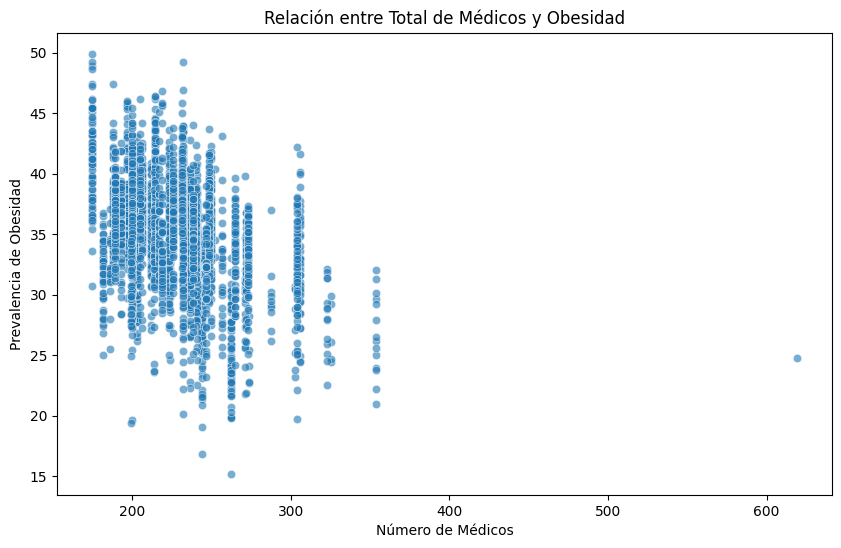

In [1114]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_new["Total_Physicians"], y=df_new["Obesity_Prevalence"], alpha=0.6)
plt.title("Relación entre Total de Médicos y Obesidad")
plt.xlabel("Número de Médicos")
plt.ylabel("Prevalencia de Obesidad")
plt.show()


En este grafico, nos dice que la obesidad puede estar influenciada por el accceso a medicos, la mayoría de los puntos están concentrados entre 150 y 350 médicos, con una prevalencia de obesidad entre 25% y 45%. 

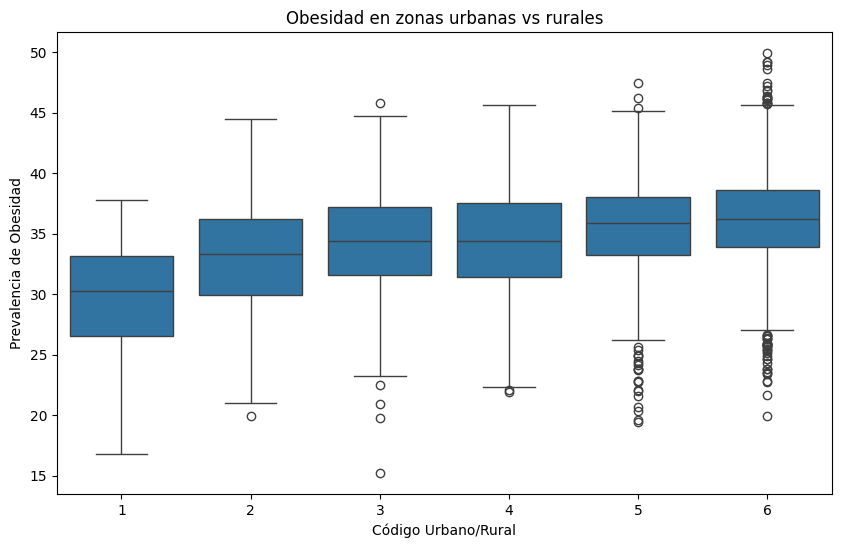

In [1115]:
#Relacion de zonas urbanas y rurales con la Obesidad

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_new["Urban_Rural_Code"], y=df_new["Obesity_Prevalence"])
plt.title("Obesidad en zonas urbanas vs rurales")
plt.xlabel("Código Urbano/Rural")
plt.ylabel("Prevalencia de Obesidad")
plt.show()

Las zonas urbanas tienen una media de obesidad alta, esto quiere decir que los entornos urbanos favorecen habitos menos saludables. Y las zonas rurales tienen menor obesidad quizas a mayor actividad fisica, mejores habitos alimenticios entre otras cosas. 

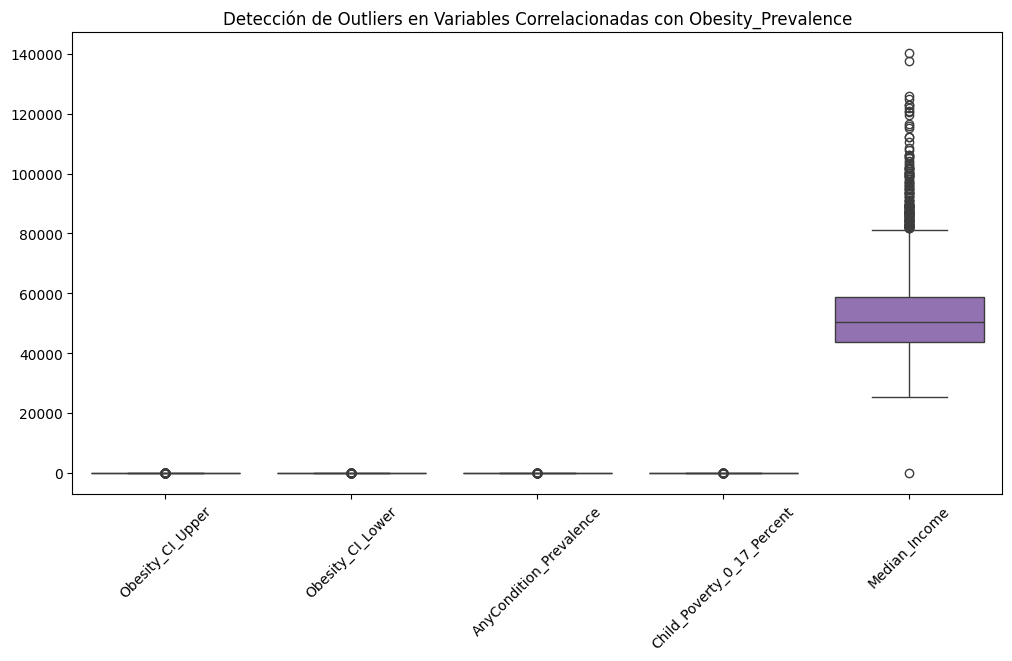

In [1116]:
# Identificar los valores atipicos 
# Variables más correlacionadas con obesidad
top_variables = ["Obesity_CI_Upper", "Obesity_CI_Lower", "AnyCondition_Prevalence", "Child_Poverty_0_17_Percent", "Median_Income"]

# Graficar boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_new[top_variables])
plt.xticks(rotation=45)
plt.title("Detección de Outliers en Variables Correlacionadas con Obesity_Prevalence")
plt.show()


El grafico nos muesta como existen valores atipicos dentro de nuestra variable, Median_Income. 

In [1117]:
# Eliminar outliers para valores atipicos en Median_Income
q1 = df_new["Median_Income"].quantile(0.25)
q3 = df_new["Median_Income"].quantile(0.75)
iqr = q3 - q1 

lower = q1 - (1.5 * iqr)
upper = q3 + (1.5 * iqr)

df_new = df_new[(df_new["Median_Income"] >= lower) & (df_new["Median_Income"] <= upper)]
print(f"Tamaño del dataset antes: {df.shape}")
print(f"Tamaño del dataset después: {df_new.shape}")


Tamaño del dataset antes: (3140, 74)
Tamaño del dataset después: (3000, 28)


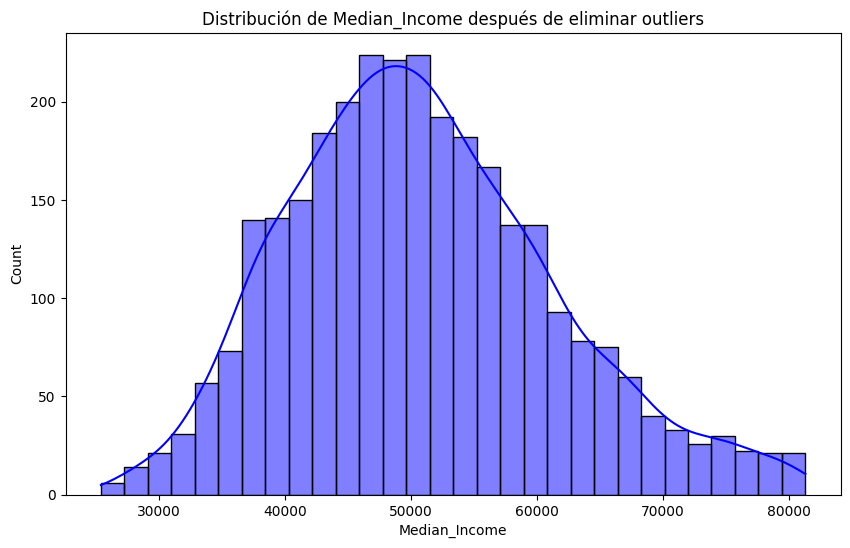

In [1118]:
# Distribucion de Median_Income luego de eliminar los outliers presentes
plt.figure(figsize=(10, 6))
sns.histplot(df_new["Median_Income"], kde=True, bins=30, color="blue")
plt.title("Distribución de Median_Income después de eliminar outliers")
plt.show()


In [1119]:
# Division del Dataset 
# entre entrenamiento y prueba 
y = df_new['Obesity_Prevalence']
X = df_new.drop(columns=['Obesity_Prevalence', 'Obesity_CI_Lower', 'Obesity_CI_Upper'], errors='ignore')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")



X_train: (2400, 25)
X_test:  (600, 25)
y_train: (2400,)
y_test:  (600,)


In [1120]:
# Escalar variables, hacerlas con solo numericas
X_train = X_train.select_dtypes(include=[float, int])
X_test = X_test.select_dtypes(include=[float, int])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Datos despues del escalado
pd.DataFrame(X_train_scaled, columns=X_train.columns).describe().head()



,Total_poblacion,Edad_0-19,Edad_20-39,Edad_40-59,Edad_60-80+,Birth_Rate,Death_Rate,Median_Income,Income_Percent_State,Total_Physicians,...,ICU_Beds,Senior_Population,Senior_Percent,Urban_Rural_Code,AnyCondition_Prevalence,Total_Poverty,Overall_Poverty_Percent,Child_Poverty_0_17_Percent,Child_Poverty_5_17_Percent,Median_Household_Income
count,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,...,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03
mean,2.960595e-18,-4.440892e-18,2.220446e-17,5.329071e-17,1.480297e-17,-4.803565e-16,-2.442491e-16,3.301063e-16,-3.982000e-16,-4.440892e-18,...,-1.406282e-17,-1.776357e-17,-4.744353e-16,1.258253e-16,-2.394381e-16,-2.960595e-18,3.863576e-16,-1.776357e-16,-2.723747e-16,3.301063e-16
std,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,...,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00
min,-3.278121e-01,-3.162923e-01,-3.042004e-01,-3.261536e-01,-3.675756e-01,-4.345202e+00,-4.019084e+00,-2.425858e+00,-2.569889e+00,-1.672116e+00,...,-2.779162e-01,-3.694296e-01,-3.447730e+00,-2.572842e+00,-3.795219e+00,-3.112485e-01,-2.044800e+00,-1.938500e+00,-1.884922e+00,-2.425858e+00
25%,-2.880735e-01,-2.797499e-01,-2.736945e-01,-2.868795e-01,-3.135621e-01,-5.801678e-01,-6.197835e-01,-7.121772e-01,-6.919988e-01,-8.333119e-01,...,-2.779162e-01,-3.131107e-01,-6.367622e-01,-5.076846e-01,-6.218833e-01,-2.712984e-01,-7.231818e-01,-7.477971e-01,-7.514184e-01,-7.121772e-01


Con relacion a estos resultados, ya ejecutada la division de los datos vamos a realizar una regresion lineal.

In [1121]:
# Modelo de Regresdion lineal (Modelo 1)
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
linreg_pred = linreg.predict(X_test_scaled)

# Prediccion
y_pred = linreg.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluación del modelo:")
print(f"MSE: {mse:.2f}")
print(f"R²): {r2:.2f}")

Evaluación del modelo:
MSE: 3.03
R²): 0.84


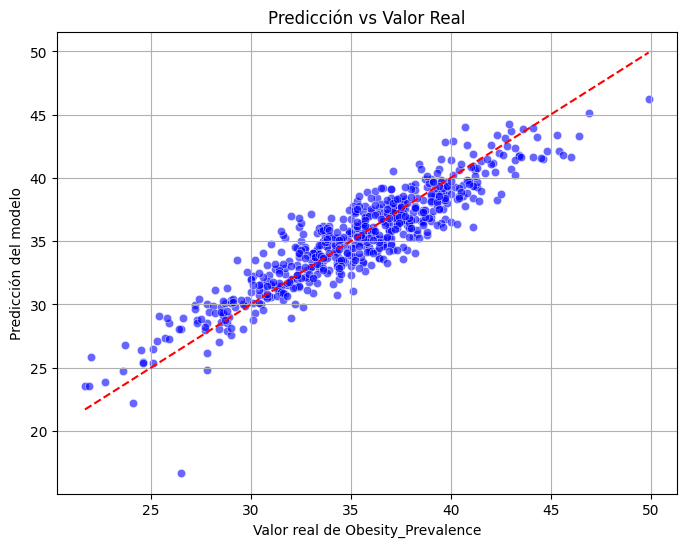

In [1122]:
# Prediccion vs Valor Real 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Valor real de Obesity_Prevalence')
plt.ylabel('Predicción del modelo')
plt.title('Predicción vs Valor Real')
plt.grid(True)
plt.show()

El modelo tiene un buen desempeño, con un R2 de 0.84, lo cual nos dice que la variabilidad esta bien explicada, Sin embargo podrian mejorarse. Para ello probaremos con otros dos modelos Ridge o Lasso, para poder comparar los resultados de una mejor manera. 

In [1123]:
#Lasso Regresion (Modelo 2)

lasso = Lasso(alpha=0.4)  # Alpha pequeño para no eliminar muchas variables
lasso.fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)

print("Lasso Regression")
print(f"R²:  {r2_score(y_test, lasso_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, lasso_pred):.3f}\n")

Lasso Regression
R²:  0.804
MSE: 3.803



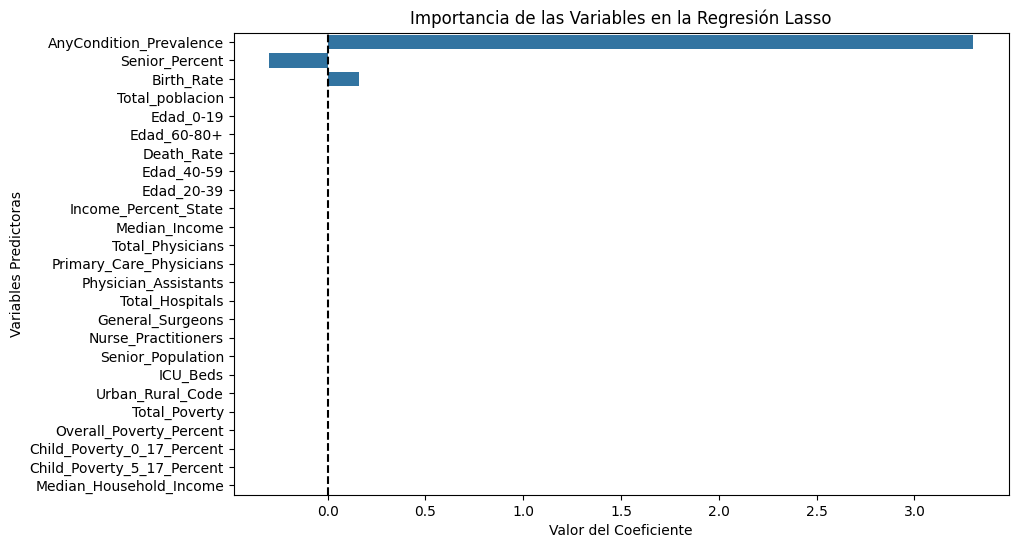

In [1124]:
# Datos del data pero para coeficientes Lasso
coef_df_new = pd.DataFrame({'Feature': X.columns, 'Coeficiente': lasso.coef_})
coef_df_new = coef_df_new.sort_values(by='Coeficiente', key=abs, ascending=False)

# Graficar coeficientes
plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Feature', data=coef_df_new)
plt.axvline(x=0, color="black", linestyle="--")
plt.xlabel("Valor del Coeficiente")
plt.ylabel("Variables Predictoras")
plt.title("Importancia de las Variables en la Regresión Lasso")
plt.show()

En regresion lineal, alguna de estas variables como por ejemplo *Anycondition_Prevalence* tenian coeficientes mas grandes. Como se puede observar el coeficientes de las variables la mayoria estan en 0, Lasso nos ayudo a filtrar estas variables y enfocarse en las mas impactantes, y eliminar las menos relevantes. Enrelaciona estos resultados, podriamos optimizar el modelo, o comporrar con Ridge.

In [1125]:
# Ridge regression (Modelo 3)
ridge = Ridge(alpha=2.0)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)

print("Ridge Regression")
print(f"R²:  {r2_score(y_test, ridge_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred):.3f}\n")

Ridge Regression
R²:  0.844
MSE: 3.034



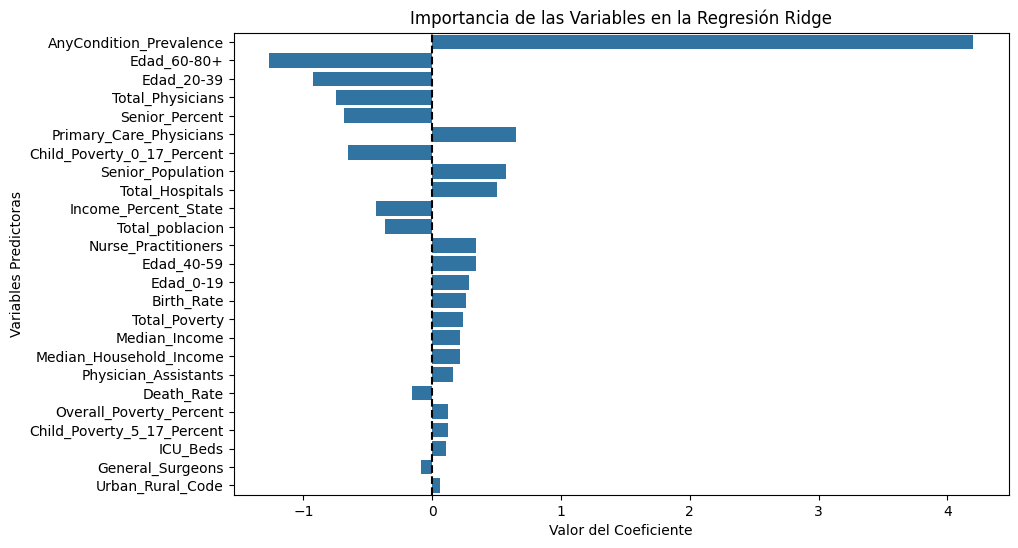

In [1126]:
# Crear DataFrame con coeficientes de Ridge
coef_df_ridge = pd.DataFrame({'Feature': X.columns, 'Coeficiente': ridge.coef_})
coef_df_ridge = coef_df_ridge.sort_values(by='Coeficiente', key=abs, ascending=False)

# Graficar coeficientes
plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Feature', data=coef_df_ridge)
plt.axvline(x=0, color="black", linestyle="--")  # Línea divisoria
plt.xlabel("Valor del Coeficiente")
plt.ylabel("Variables Predictoras")
plt.title("Importancia de las Variables en la Regresión Ridge")
plt.show()


Aqui podemos deducir que Ridge tiene mas impacto en las variables que Lasso. Este modelo permite mayor conservacion de infromacion y tiene una ajuste mas precision. 

In [1127]:
#Regresion con Lasso CV Modelo 3
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)
lasso_cv_pred = lasso_cv.predict(X_test_scaled)

print("LassoCV Regression")
print(f"Mejor alpha encontrado: {lasso_cv.alpha_:.4f}")
print(f"R²:  {r2_score(y_test, lasso_cv_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, lasso_cv_pred):.3f}\n")

LassoCV Regression
Mejor alpha encontrado: 0.0042
R²:  0.849
MSE: 2.930



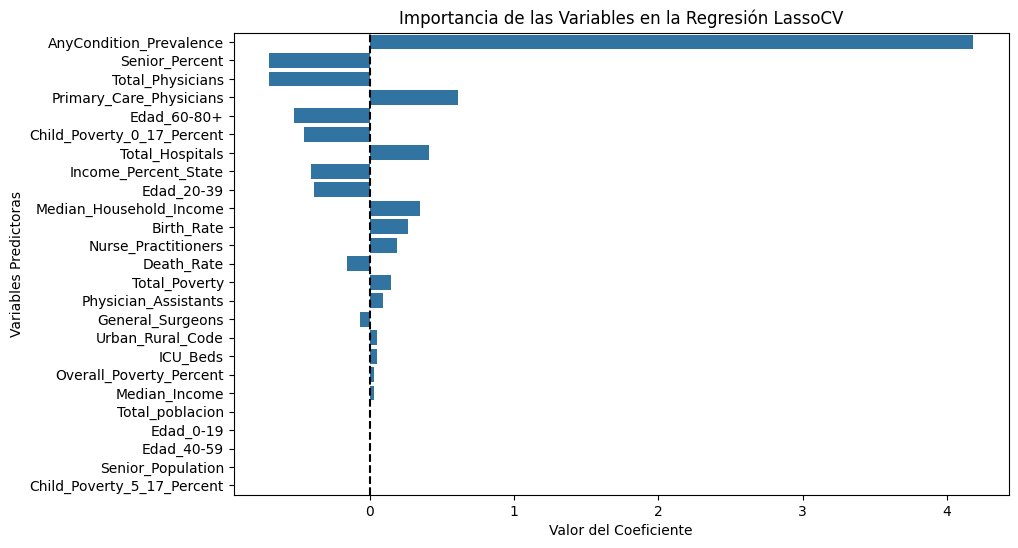

In [1128]:
# Crear DataFrame con coeficientes de Lasso
coef_df_lasso = pd.DataFrame({'Feature': X_train.columns, 'Coeficiente': lasso_cv.coef_})
coef_df_lasso = coef_df_lasso.sort_values(by='Coeficiente', key=abs, ascending=False)

# Graficar coeficientes
plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Feature', data=coef_df_lasso)
plt.axvline(x=0, color="black", linestyle="--")  # Línea divisoria
plt.xlabel("Valor del Coeficiente")
plt.ylabel("Variables Predictoras")
plt.title("Importancia de las Variables en la Regresión LassoCV")
plt.show()


LassoCv nos ayudo a eliminar los coeficientes cercanos a 0 porque su impacto en la obesidad es bajo,LassoCv elimino mas coeficientes pequeños en relacion con Ridge. Un alpha pequeño nos ayuda a conservar informacion mas importante. El modelo explica el 84.9% lo cual confirma que es un modelo confiable, el error cuadratico es mmedio-bajo lo cual tiene buena precision, mucho mejor que los modelos anteriores. 

In [1129]:
# Evaluamos todos los modelos
modelos_resultados = {
    'Modelo': ['LinearRegression', 'Ridge', 'Lasso', 'LassoCV'],
    'R²': [
        r2_score(y_test, linreg_pred),
        r2_score(y_test, ridge_pred),
        r2_score(y_test, lasso_pred),
        r2_score(y_test, lasso_cv_pred)
    ],
    'MSE': [
        mean_squared_error(y_test, linreg_pred),
        mean_squared_error(y_test, ridge_pred),
        mean_squared_error(y_test, lasso_pred),
        mean_squared_error(y_test, lasso_cv_pred)
    ]
}

# Mostrar tabla comparativa
resultados_df = pd.DataFrame(modelos_resultados)
print("Comparativa de Modelos de Regresión:")
display(resultados_df.sort_values(by='R²', ascending=False))


Comparativa de Modelos de Regresión:


,Modelo,R²,MSE
3,LassoCV,0.849054,2.930171
0,LinearRegression,0.843720,3.033713
1,Ridge,0.843715,3.033810
2,Lasso,0.804112,3.802582


Fin de los resultados:
-  LassoCV es el mejor modelo: tiene el R² más alto (0.849), es decir que explica casi el 85% de la obesidad, y el MSE más bajo (2.93), menor error de predicción promedio.

-  Linear Regression y Ridge tienen un rendimiento casi idéntico,
-  Lasso sin CV, tiene el peor desempeño, R² = 0.80, MSE = 3.80, seguramente se sobreajustó o eliminó demasiadas variables con un alpha mal elegido.